# Understanding K-Nearest Neighbors (KNN) with Scikit-Learn

K-Nearest Neighbors (KNN) is a simple, supervised machine learning algorithm that can be used for both classification and regression tasks. It's known as a non-parametric, instance-based learning or lazy learning algorithm.

* Non-parametric: It doesn't make any assumptions about the underlying data distribution.
* Instance-based: It doesn't learn an explicit function from the training data. Instead, it memorizes the training instances, which are then used during the prediction phase.
* Lazy learning: It doesn't build a model during the training phase. All the computation is deferred until prediction time.

### How KNN Works

The core idea behind KNN is straightforward:

1. Calculate Distances: When predicting the label (for classification) or value (for regression) of a new data point, KNN calculates the distance between this new point and all points in the training dataset. Common distance metrics include:
* Euclidean Distance: The most common metric, representing the straight-line distance between two points in Euclidean space.
$$ d(p, q) = \\sqrt{\\sum_{i=1}^{n}(p_i - q_i)^2} $$
* Manhattan Distance: The sum of the absolute differences of their Cartesian coordinates.
$$ d(p, q) = \\sum_{i=1}^{n}|p_i - q_i| $$
* Minkowski Distance: A generalization of both Euclidean and Manhattan distances.
$$ d(p, q) = \\left(\\sum_{i=1}^{n}|p_i - q_i|^p\\right)^{1/p} $$
(Euclidean is Minkowski with p=2, Manhattan is Minkowski with p=1).

2. Find Nearest Neighbors: It identifies the 'K' training data points that are closest (have the smallest distances) to the new data point. 'K' is a user-defined integer constant.

3. Predict:
* For Classification: The algorithm assigns the class label that is most frequent among the K nearest neighbors (majority vote).
* For Regression: The algorithm predicts the average (or sometimes median) of the values of the K nearest neighbors.\n\nThis notebook will focus on KNN for classification.

### Choosing the Value of K

The choice of 'K' significantly impacts the KNN algorithm's performance:

* Small K (e.g., K=1): The model can be very sensitive to noise and outliers. The decision boundary might be complex and prone to overfitting.
* Large K: The model becomes smoother and less sensitive to noise, potentially leading to underfitting. The decision boundary becomes simpler. If K is too large (e.g., K = number of training samples), it might always predict the majority class in the dataset.

How to choose K?
* There's no definitive way to determine the best K beforehand.
* A common approach is to try different values of K (e.g., using cross-validation) and select the one that yields the best performance on a validation set.
* Often, an odd value for K is chosen for binary classification to avoid ties in voting.
* A rule of thumb is to set K = sqrt(n), where n is the number of samples, but this should be validated.

### Pros and Cons of KNN

Pros:
* Simple and Intuitive: Easy to understand and implement.
* No Training Phase: As a lazy learner, it requires no explicit training step.
* Adapts Easily: New data can be added easily without retraining a model.
* Non-parametric: Makes no assumptions about the data distribution.
* Good for Multi-class Problems: Naturally extends to multi-class classification.

Cons:
* Computationally Expensive: Calculating distances to all training points can be slow, especially for large datasets (high time complexity for prediction).
* High Memory Requirement: Need to store the entire training dataset.
* Sensitive to Irrelevant Features: Features that don't contribute much to the distance calculation can negatively impact performance (curse of dimensionality).
* Sensitive to Feature Scaling: Features with larger ranges can dominate the distance calculation. Therefore, feature scaling (like standardization or normalization) is crucial.
* Sensitive to K: Performance heavily depends on the choice of K.

### Implementation with Scikit-Learn

#### 1. Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.datasets import make_classification # To generate synthetic data

# Configure plots for better visualization
# Check available styles and use a compatible one if seaborn-v0_8-whitegrid is not found
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('ggplot') # Fallback style
    print("Style 'seaborn-v0_8-whitegrid' not found, using 'ggplot' instead.")

#### 2. Load/Generate Data

Let's generate some synthetic data for a binary classification problem using make_classification from scikit-learn. This allows us to control the properties of the data for demonstration purposes. Alternatively, you could load a standard dataset like Iris or Breast Cancer.

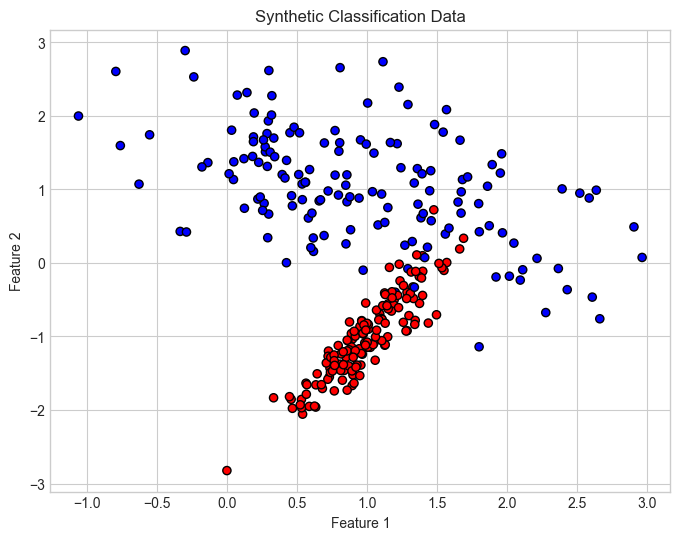

First 5 rows of the dataset:
   Feature 1  Feature 2  Target
0   0.733246  -1.431007       0
1   0.656043   0.842841       1
2   0.537983  -2.056550       0
3   1.289308  -0.079023       1
4   0.720124   0.977237       1


In [2]:
# Generate synthetic data
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1, class_sep=1.0)

# Visualize the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolors='k', s=35)
plt.title('Synthetic Classification Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

# Convert to DataFrame for easier viewing (optional)
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['Target'] = y
print("First 5 rows of the dataset:")
print(df.head())

#### 3. Train/Test Split

Before applying KNN, we need to split our dataset into a training set (used to \"train\" the lazy learner, i.e., store the data) and a test set (used to evaluate its performance on unseen data).

In [3]:
# Split the dataset into Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 225 samples
Test set size: 75 samples


#### 4. Feature Scaling

Crucial Step for KNN: Since KNN relies on distance calculations, features with larger values can disproportionately influence the result. For example, if one feature ranges from 0-1 and another from 0-1000, the second feature will dominate the distance calculation.

We need to scale the features so they have a comparable range. StandardScaler is a common technique that transforms the data to have a mean of 0 and a standard deviation of 1.

Important: We fit the scaler only on the training data and then use it to transform both the training and test data. This prevents data leakage from the test set into the training process.

In [4]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the same scaler fitted on train data

# Display scaled data (optional)
print("\nFirst 5 rows of scaled training data:")
print(pd.DataFrame(X_train_scaled, columns=['Feature 1', 'Feature 2']).head())


First 5 rows of scaled training data:
   Feature 1  Feature 2
0   1.158657   0.800447
1  -0.104044  -1.341687
2  -0.015160  -1.231422
3  -0.428663   0.317358
4  -1.527740   1.000444


#### 5. Training the KNN Model

Now we create and \"train\" the KNN classifier using scikit-learn's KNeighborsClassifier.

Key parameters:
* n_neighbors: This is the 'K' value. We'll start with a common value like 5.
* metric: The distance metric to use (default is 'minkowski' with p=2, which is equivalent to 'euclidean').
* p: Power parameter for the Minkowski metric.

In [5]:
# Create and train the KNN classifier
k_value = 5
classifier = KNeighborsClassifier(n_neighbors=k_value, metric='minkowski', p=2)

# Note: For KNN, 'fit' primarily stores the training data
classifier.fit(X_train_scaled, y_train)
print(f"KNN Classifier created with K={k_value}")

KNN Classifier created with K=5


#### 6. Making Predictions

With the \"trained\" classifier (which has stored the scaled training data), we can now predict the class labels for the unseen test data.

In [6]:
# Predict the Test set results
y_pred = classifier.predict(X_test_scaled)

# Display predictions vs actual values (optional)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print("\nFirst 10 predictions:")
print(results_df.head(10))


First 10 predictions:
   Actual  Predicted
0       0          0
1       1          1
2       1          1
3       0          0
4       1          1
5       1          1
6       1          1
7       1          1
8       0          0
9       1          1


#### 7. Evaluating the Model

We evaluate the model's performance using common classification metrics:

* Confusion Matrix: A table showing correct and incorrect predictions broken down by class.
* True Positives (TP): Correctly predicted positive class.
* True Negatives (TN): Correctly predicted negative class.
* False Positives (FP): Incorrectly predicted positive class (Type I error).
* False Negatives (FN): Incorrectly predicted negative class (Type II error).
* Accuracy: The proportion of correct predictions overall (TP + TN) / Total.
* Classification Report: Provides precision, recall, and F1-score for each class.
* Precision: TP / (TP + FP) - Out of all predicted positives, how many were actually positive?
* Recall (Sensitivity): TP / (TP + FN) - Out of all actual positives, how many were correctly identified?
* F1-Score: The harmonic mean of precision and recall (2 * Precision * Recall) / (Precision + Recall).

In [7]:
# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n--- Model Evaluation (K=5) ---")
print("Confusion Matrix:")
print(cm)
# Nicer print for confusion matrix
print(f"\nTrue Negatives: {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives: {cm[1, 1]}")

print(f"\nAccuracy: {acc:.4f}")

print("\nClassification Report:")
print(report)


--- Model Evaluation (K=5) ---
Confusion Matrix:
[[35  1]
 [ 2 37]]

True Negatives: 35
False Positives: 1
False Negatives: 2
True Positives: 37

Accuracy: 0.9600

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.97      0.95      0.96        39

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



#### 8. Visualizing the Decision Boundary

For datasets with two features, we can visualize the decision boundary learned by the classifier. This shows how the model divides the feature space into regions corresponding to different classes. We'll plot the boundary for both the training and test sets.

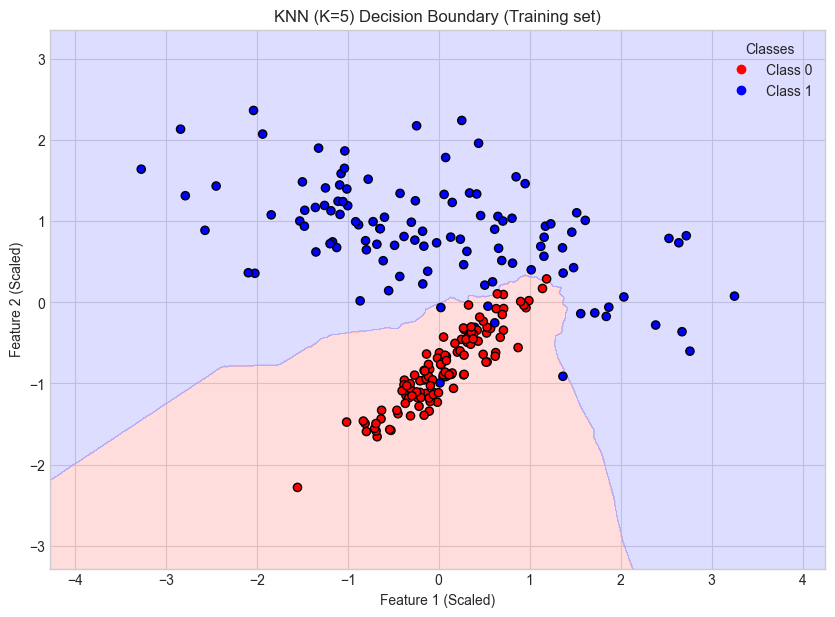

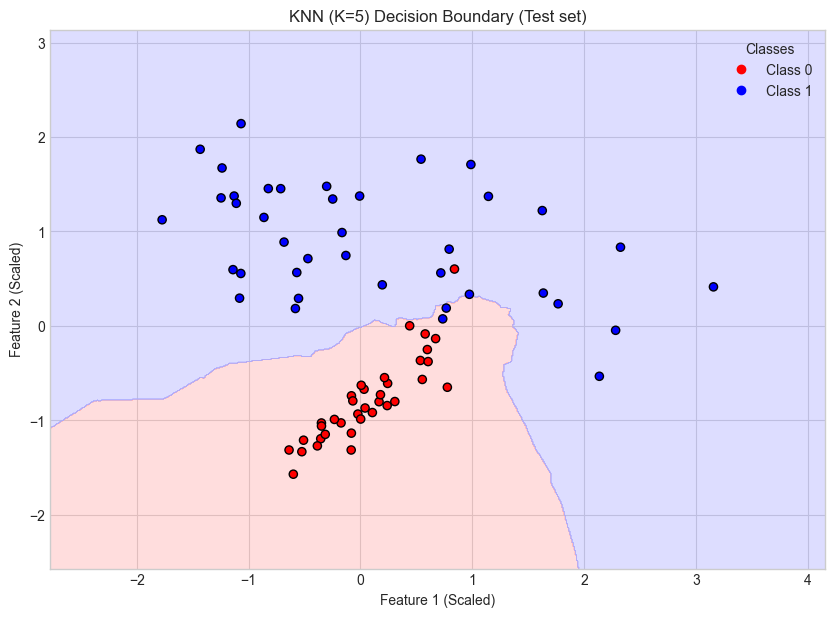

In [8]:
# Function to plot decision boundaries
def plot_decision_boundary(X, y, classifier, title):
# Assuming X passed is already scaled
    X_set, y_set = X, y 
    
    # Create mesh grid
    x_min, x_max = X_set[:, 0].min() - 1, X_set[:, 0].max() + 1
    y_min, y_max = X_set[:, 1].min() - 1, X_set[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict the class for each point in the mesh grid
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and the data points
    plt.figure(figsize=(10, 7))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF']) # Light red/blue background
    cmap_bold = ListedColormap(['#FF0000', '#0000FF']) # Red/blue points
    
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    # Plot the actual data points
    scatter = plt.scatter(X_set[:, 0], X_set[:, 1], c=y_set, cmap=cmap_bold, edgecolors='k', s=35)
    # Create legend handles manually
    try:
        handles, labels = scatter.legend_elements()
        class_labels = [f'Class {i}' for i in np.unique(y)] # Assuming y contains 0 and 1
        plt.legend(handles=handles, labels=class_labels, title="Classes")
    except ValueError:
        print("Could not generate legend elements. Ensure data points exist for all classes.")
        
    plt.title(title)
    plt.xlabel('Feature 1 (Scaled)')
    plt.ylabel('Feature 2 (Scaled)')
    plt.grid(True)
    plt.show()

# Plot for Training Set (using scaled data)
plot_decision_boundary(X_train_scaled, y_train, classifier, f'KNN (K={k_value}) Decision Boundary (Training set)')

# Plot for Test Set (using scaled data)
plot_decision_boundary(X_test_scaled, y_test, classifier, f'KNN (K={k_value}) Decision Boundary (Test set)')

#### 9. Finding an Optimal K

As discussed, the choice of K is crucial. We can iterate through different values of K and see how the accuracy (or error rate) changes on the test set. This helps in selecting a potentially better K value than our initial guess of 5.

We typically plot the error rate (1 - accuracy) against K values.

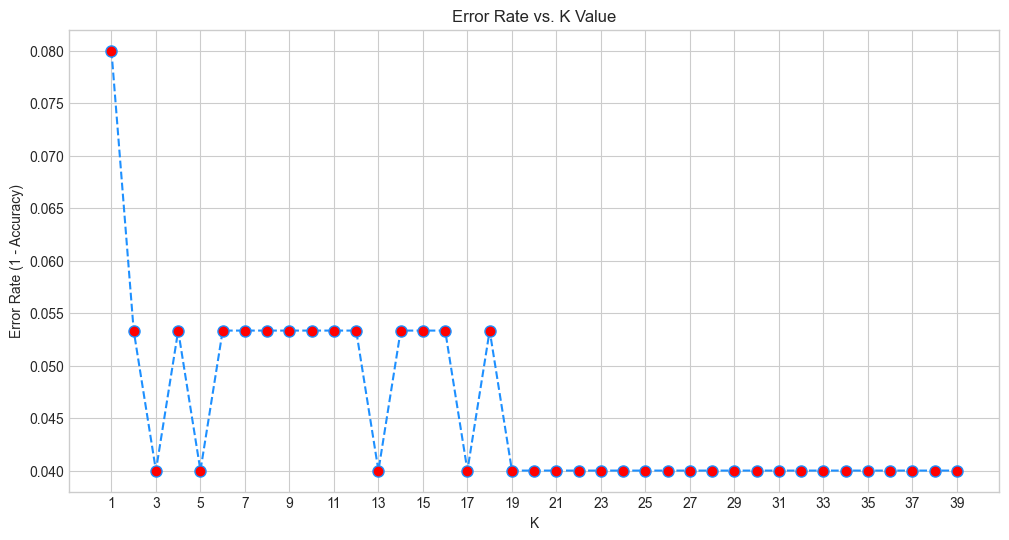


Minimum error rate (0.0400) found at K = 3

Accuracy with optimal K=3: 0.9600

Classification Report (Optimal K):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.97      0.95      0.96        39

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



In [9]:
error_rate = []
k_range = range(1, 40) # Test K values from 1 to 39

for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    # Calculate error rate (1 - accuracy)
    error_rate.append(np.mean(pred_i != y_test))

# Plotting the error rate vs K value
plt.figure(figsize=(12, 6))
plt.plot(k_range, error_rate, color='dodgerblue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.xticks(np.arange(min(k_range), max(k_range)+1, 2)) # Show ticks every 2 K values
plt.grid(True)
plt.show()

# Find the K with the minimum error rate
min_error = min(error_rate)
optimal_k_index = error_rate.index(min_error)
optimal_k = k_range[optimal_k_index]
print(f"\nMinimum error rate ({min_error:.4f}) found at K = {optimal_k}")

# Optional: Train and evaluate with the optimal K
classifier_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
classifier_optimal.fit(X_train_scaled, y_train)
y_pred_optimal = classifier_optimal.predict(X_test_scaled)
acc_optimal = accuracy_score(y_test, y_pred_optimal)
print(f"\nAccuracy with optimal K={optimal_k}: {acc_optimal:.4f}")
print("\nClassification Report (Optimal K):")
print(classification_report(y_test, y_pred_optimal))

### Conclusion

This notebook provided a detailed explanation of the K-Nearest Neighbors algorithm, including its intuition, implementation steps using scikit-learn, the importance of feature scaling, model evaluation, and a method for choosing an optimal K value.

KNN is a fundamental algorithm in machine learning, valuable for its simplicity and effectiveness in certain scenarios, especially when the decision boundary is irregular and no strong assumptions can be made about the data distribution. However, its computational cost and sensitivity to feature scaling and dimensionality must be considered.